# What is the driving force of GNF? - 4

Local fluctuations might be related to energy, enstrophy and vorticity. 

## 1. Improve the speed of df2 code

In the old implementation, it took 30 s to calculate the variation over 50 frames, where only 9 boxes were taken into account. Imagine if we want to sample the whole image and get local variation everywhere, 50 frames will take several minutes. Here, we try to speed up the code by vectorization.

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corrLib
from skimage import io
import os
from corr_utils import *
import time
from myImageLib import dirrec
from scipy.signal import savgol_filter

### 1.1 Vectorized code

In [2]:
img_folder = r'E:\moreData\08032020\00\8-bit'

In [109]:
%%time
img_nums = range(901, 950)
l = corrLib.readseq(img_folder).loc[img_nums]
img_seq = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    img_seq.append(I) 
img_stack = np.stack([img_seq], axis=0)
img_stack = np.squeeze(img_stack)
std = np.std(img_stack, axis=0)

Wall time: 510 ms


### 1.2 Old code

In [107]:
%%time
img_nums = range(901, 950)
l = corrLib.readseq(img_folder).loc[img_nums]
df = pd.DataFrame()
for num, i in l.iterrows():
    img = io.imread(i.Dir)    
    X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
    tempdf = pd.DataFrame().assign(I=I.flatten(), t=int(i.Name), number=range(0, len(I.flatten())))
    df = df.append(tempdf)
stdL = []
nL = []
for n in df.number.drop_duplicates():
    subdata = df.loc[df.number==n]
    std = subdata.I.std()
    stdL.append(std)
    nL.append(n)
std = np.array(stdL).reshape(42, 50)

Wall time: 2.65 s


### 1.3 Conclusion
New algorithm is faster by ~5 times than old algorithm. They give the same results.

## 2. Compute vorticity

In [21]:
def vorticity(pivData, step=None, shape=None):
    """
    Compute vorticity field based on piv data (x, y, u, v)
    
    Args:
    pivData -- DataFrame of (x, y, u, v)
    step -- distance (pixel) between adjacent PIV vectors
    
    Returns:
    vort -- vorticity field of the velocity field. unit: [u]/pixel, [u] is the unit of u, usually px/s
    """
    x = pivData.sort_values(by=['x']).x.drop_duplicates()
    if step == None:
        # Need to infer the step size from pivData
        step = x.iat[1] - x.iat[0]
    
    if shape == None:
        # Need to infer shape from pivData
        y = pivData.y.drop_duplicates()
        shape = (len(y), len(x))
        
    X = np.array(pivData.x).reshape(shape)
    Y = np.array(pivData.y).reshape(shape)
    U = np.array(pivData.u).reshape(shape)
    V = np.array(pivData.v).reshape(shape)
    
    dudy = np.gradient(U, step, axis=0)
    dvdx = np.gradient(V, step, axis=1)
    vort = dvdx - dudy
    
    return vort

In [112]:
piv_folder = r'E:\moreData\08032020\piv_imseq\00'
pivData = pd.read_csv(os.path.join(piv_folder, '0900-0901.csv'))
X = np.array(pivData.x).reshape(42, 50)
Y = np.array(pivData.y).reshape(42, 50)
U = np.array(pivData.u).reshape(42, 50)
V = np.array(pivData.v).reshape(42, 50)

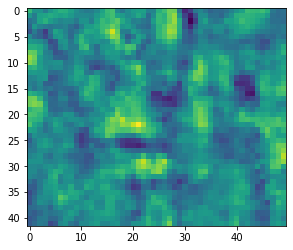

In [182]:
vort = vorticity(pivData)
plt.imshow(vort)

## 3. Compute local density fluctuation time series

### 3.1 local density fluctuations function

In [218]:
def local_df(img_folder, seg_length=50, winsize=50, step=25):
    """
    Compute local density fluctuations of given image sequence in img_folder
    
    Args:
    img_folder -- folder containing .tif image sequence
    seg_length -- number of frames of each segment of video, for evaluating standard deviations
    winsize --
    step --
    
    Returns:
    df -- dict containing 't' and 'local_df', 't' is a list of time (frame), 'std' is a list of 2d array 
          with local standard deviations corresponding to 't'
    """
    
    l = corrLib.readseq(img_folder)
    num_frames = len(l)
    assert(num_frames>seg_length)
    
    stdL = []
    tL = range(0, num_frames, seg_length)
    for n in tL:
        img_nums = range(n, min(n+seg_length, num_frames))
        l_sub = l.loc[img_nums]
        img_seq = []
        for num, i in l_sub.iterrows():
            img = io.imread(i.Dir)
            X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
            img_seq.append(I)
        img_stack = np.stack([img_seq], axis=0)
        img_stack = np.squeeze(img_stack)
        std = np.std(img_stack, axis=0)
        stdL.append(std)
        
    return {'t': tL, 'std': stdL}

In [228]:
# local_df test code
img_folder = r'E:\moreData\08032020\08\8-bit'
l = corrLib.readseq(img_folder)
print('number of images: ' + str(len(l)) + ', time needed: {:.2f} s'.format(18.34/1785*len(l)))
tic = time.monotonic()
df = local_df(img_folder)
toc = time.monotonic()
print('time taken: {:.2f} s'.format(toc-tic))

number of images: 3600, time needed: 36.99 s
time taken: 162.09 s


### 3.2 Save the results

In [229]:
save_folder = r'E:\moreData\08032020\local_df\08'
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
for t, std in zip(df['t'], df['std']):
    np.save(os.path.join(save_folder, '{:04d}.npy'.format(t)), std)

### 3.3 Load the results

In [15]:
save_folder = r'E:\moreData\08032020\local_df\00'
l = dirrec(save_folder, '*.npy')
t = []
std = []
for i in l:
    f, n = os.path.split(i)
    name = n.split('.')[0]
    t.append(int(name))
    std.append(np.load(i))

## 4. Compute vorticity time series

### 4.1 Compute and save

In [230]:
piv_folder = r'E:\moreData\08032020\piv_imseq\08'
save_folder = r'E:\moreData\08032020\vorticity\08'
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
l = corrLib.readdata(piv_folder)
print('Number of data: ' + str(len(l)) + ', time needed: {:.2f} s'.format(len(l)/1800*47.20))
tic = time.monotonic()
for num, i in l.iterrows():
    pivData = pd.read_csv(i.Dir)
    vort = vorticity(pivData)
    np.save(os.path.join(save_folder, i.Name+'.npy'), vort)
toc = time.monotonic()
print('Time taken: {:.2f} s'.format(toc-tic))

Number of data: 1800, time needed: 47.20 s
Time taken: 53.17 s


### 4.2 Load the results

In [ ]:
vort = np.load(os.path.join(save_folder, '3500-3501.npy'))

## 5. Correlation between vorticity field and local density fluctuations

### 5.1 One-frame correlation

In [41]:
df_folder = r'E:\moreData\08032020\local_df\01'
vort_folder = r'E:\moreData\08032020\vorticity\01'

starting_frame = 600
local_df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame, starting_frame+1)))

corr2d(local_df, vort**2)

0.0015613050040485835

### 5.2 Add more statistics: average over multiple frames

Averge correlation between vorticity square and local density fluctuations is 0.007


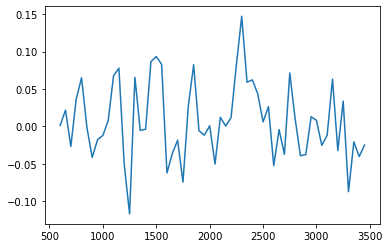

In [45]:
frame_list = range(600, 3500, 50)
corrL = []
for starting_frame in frame_list:
    local_df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
    vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame, starting_frame+1)))
    corrL.append(corr2d(local_df, vort**2))
plt.plot(frame_list, corrL)
print('Averge correlation between vorticity square and local density fluctuations is {:.3f}'.format(np.array(corrL).mean()))

## 6. Correlation between vorticity and local df at different time

It's possible that the effect of vorticity on density fluctuations, or the opposite effect, has a delay time, i.e. the vorticity field at time $t_1$ results in a density fluctuations pattern at $t_2$. In this section, I vary $\Delta t$ between vorticity field and density fluctuations field, see if there exists a $\Delta t$ with significantly higher correlation. 

### 6.1 One-frame different time correlation

In [55]:
df_folder = r'E:\moreData\08032020\local_df\01'
vort_folder = r'E:\moreData\08032020\vorticity\01'
dt = 20
starting_frame = 900

local_df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))

corr2d(local_df, vort**2)

0.03425146629825328

### 6.2 Add more statistics to a $\Delta t$ value

$\Delta t$ is -90, averge correlation is 0.018


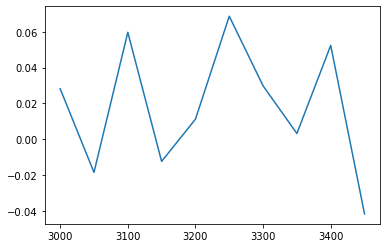

In [110]:
df_folder = r'E:\moreData\08032020\local_df\04'
vort_folder = r'E:\moreData\08032020\vorticity\04'
dt = -90

frame_list = range(3000, 3500, 50)
corrL = []
for starting_frame in frame_list:
    local_df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
    vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
    corrL.append(corr2d(local_df, vort**2))
plt.plot(frame_list, corrL)
print('$\Delta t$ is {0:d}, averge correlation is {1:.3f}'.format(dt, np.array(corrL).mean()))

### 6.3 Vary $\Delta t$ identify a highest correlation

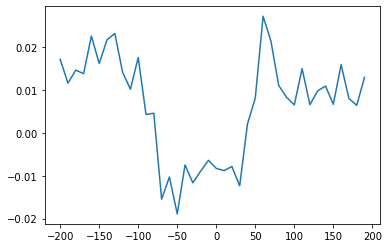

In [249]:
df_folder = r'E:\moreData\08032020\local_df\05'
vort_folder = r'E:\moreData\08032020\vorticity\05'
dtL = range(-200, 200, 10)
frame_list = range(2500, 3000, 50)

corrL = []
for dt in dtL:
    temp = []
    for starting_frame in frame_list:
        local_df = np.load(os.path.join(df_folder, '{:04d}.npy'.format(starting_frame)))
        vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
        temp.append(corr2d(local_df, vort))
    corrL.append(np.array(temp).mean())
plt.plot(dtL, corrL)

## 7. Correlation between concentration and vorticity

### 7.1 One-frame test

In [181]:
img_folder = r'E:\moreData\08032020\01\8-bit'
vort_folder = r'E:\moreData\08032020\vorticity\01'
dt = 0
starting_frame = 3300

img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(starting_frame)))
X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))

corr2d(I, vort**2)

-0.005903518911753631

### 7.2 Vary $\Delta t$

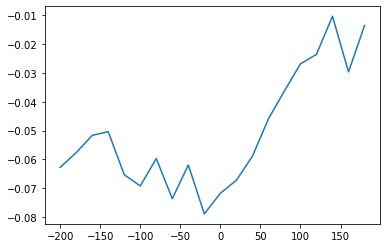

In [256]:
img_folder = r'E:\moreData\08032020\06\8-bit'
vort_folder = r'E:\moreData\08032020\vorticity\06'
dtL = range(-200, 200, 20)
frame_list = range(2500, 3200, 50)

corrL = []
for dt in dtL:
    temp = []
    for starting_frame in frame_list:
        img = io.imread(os.path.join(img_folder, '{:04d}.tif'.format(starting_frame)))
        X, Y, I = corrLib.divide_windows(img, windowsize=[50, 50], step=25)
        vort = np.load(os.path.join(vort_folder, '{0:04d}-{1:04d}.npy'.format(starting_frame+dt, starting_frame+dt+1)))
        temp.append(corr2d(I, vort**2))
    corrL.append(np.array(temp).mean())
plt.plot(dtL, corrL)

In [85]:
piv_folder = r'E:\moreData\08032020\piv_imseq\00'
pivData = pd.read_csv(os.path.join(piv_folder, '0900-0901.csv'))

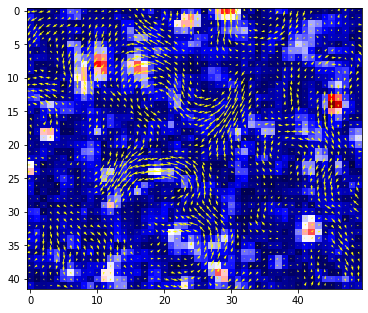

In [111]:
plt.figure(figsize=(6, 6))
plt.imshow(std, cmap='seismic')
plt.quiver((pivData.x-25)/25, (pivData.y-25)/25, pivData.u, pivData.v, color='yellow')